In [ ]:
# mount google drive 

import os, sys 
from google.colab import drive

drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/가사유사도기반추천

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/가사유사도기반추천


## **가사 전처리_0**

- 의미 없는 내용(1, 2절, verse)이 발견된 49개 데이터에 대해 이를 제거하였습니다.
- 띄어쓰기가 연속 중첩 되어있는 것을 제거하였습니다.

## **가사 전처리_1 : 연속된 한글자 추임새 없애기**
---
- 다중 공백만 제거한 버전: remove_blank.csv
- 공백 제거 **+** '아', 'ya' 제거한 버전: remove_meaningless.csv

- 띄어쓰기 기준 한글자인 요소 count: output.txt

<br>

데이터를 살펴보니 의미없이 연속되는 표현이 보였습니다.
추임새는 보통 1글자이기 때문에 제거해야 할 추임새를 찾기 위해 가사 안의 단어 중 길이가 1인 단어들 개수를 구합니다. 출력 길이 제한이 있기 때문에 output.txt 파일에 결과를 입력하여 살펴보았습니다.

연속으로 중복되는 단어를 모두 지우면 의미 있는 표현이 제거될 수 있기 때문에 이 같은 과정을 거쳤습니다.

이에 따라 '아'. 'ya'가 의미없이 반복되는 표현이라고 판단되어 제거하였습니다.


In [ ]:
import pandas as pd
from itertools import groupby
import re

In [ ]:
df = pd.read_csv("./data/lyrics_all_new.csv")

In [ ]:
#다중 공백 지우기
"""
for i, l in enumerate(df['lyrics']):
    df['lyrics'][i] = re.sub('\s+', ' ', l).strip()
"""

"\nfor i, l in enumerate(df['lyrics']):\n    df['lyrics'][i] = re.sub('\\s+', ' ', l).strip()\n"

In [ ]:
#하나 짜리 찾기
"""
from collections import Counter

sys.stdout = open('./output.txt','w')

for i, l in enumerate(df['lyrics']):
    l = l.split()
    tmp = list(filter(lambda x: len(x)==1, l))
    print("{}번째 {}" .format(i,Counter(tmp)))
    open('output.txt','a')

"""

'\nsys.stdout = open(\'./output.txt\',\'w\')\n\nfor i, l in enumerate(df[\'lyrics\']):\n    l = l.split()\n    tmp = list(filter(lambda x: len(x)==1, l))\n    print("{}번째 {}" .format(i,Counter(tmp)))\n    open(\'output.txt\',\'a\')\n\n'

In [ ]:
#'아', 'ya' 제거
for i, l in enumerate(df['lyrics']):
    l = l.split()
    tmp = [item for item in l if item != '아' and item != 'ya']
    tmp = ' '.join(tmp)
    df['lyrics'][i] = tmp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.to_csv('./remove_meaningless.csv', index = False, encoding='utf-8-sig')

## **가사전처리_2: 가사 데이터 한글로 번역하기**
---
가사가 모두 영어로 구성되어 있는 경우와 영어와 한글이 섞여 있는 경우가 존재하였습니다. 따라서 언어를 통일 전처리를 진행할 경우 어떤 변화가 있을 지 살펴보기 위해 번역 전처리를 진행해보았습니다.

- index 5009까지 모두 영어로 된 가사(lyrics) 한국어로 번역: translate.csv
- 파파고 번역 API 사용



In [ ]:
import pandas as pd
import json
import re

In [ ]:
df2 = pd.read_csv("./data/translate.csv")
print(df2['lyrics'])

0        무얼 믿은 걸까 부족했던 내게서 나조차 못 믿던 내게 여태 머문 사람 무얼 봤던 걸...
1        궂은 비가 내리는 연안부두에서 우연히 만난 그대 사랑을 속삭였네 진정으로 사랑했었네...
2        친구야 생각나냐 꼴망테 둘러메고 소꼴 베는 언덕넘어 해지는 풍경속 어린시절 친구야 ...
3        나도 한 때는 남부럽지 않게 잘 나가던 때가 있었지만 한 순간에 인생 꼬여보니 한숨...
4        말만하면 뚝뚝뚝 눈물만 흘리는 당신 이슬 초라 부를까요 눈물마저 너무 예뻐서 더 이...
                               ...                        
10752    Hey boy 잠시 얘길 들어 봐 오랫동안 준비한 이 맘을 이제 나 전하고 싶어 이...
10753    Psycho 널 어쩌면 좋을까 이런 맘은 또 첨이라 Up amp Down이 좀 심해...
10754    I don t even know what I m sayin 이 감정은 뭔지 참 대담...
10755    영원한 밤 창문 없는 방에 우릴 가둔 love What can we say 매번 아...
10756    1step 2step move your body 3step 4step shake y...
Name: lyrics, Length: 10757, dtype: object


In [ ]:
#한글 + 영어 + 한글일 경우
# 한글 아닌거 감지되면 슬라이스(다시 한글인거 감지 될 때까지) 
#분리한거 파파고 api에 넣기
#다시 합치기

def hasEnglish(input_s):
    for c in input_s:
        if ord('a') <= ord(c.lower()) <= ord('z'):
            return True


hasEn = []

for i, l in enumerate(df2['lyrics']):
    if hasEnglish(l):
        hasEn.append(i)

In [ ]:
for i in hasEn[:3]:
    print("인덱스 번호: {}, 가사 {}" .format(i,df2['lyrics'][i]))

인덱스 번호: 12, 가사 그대 내 마음을 몰라 처음부터 그대 사랑한 줄 몰라 가슴이 두근두근 떨려 입술이 바싹바싹 말라 오늘은 참지 말고 그대 사랑을 속삭여줘요 뜨거운 내 가슴은 이미 그대만 와 준다면 All Right 더 이상 망설이지 말고 나를 가져가세요 그댄 자꾸 내 영혼을 흔들어요 내 심장이 터지도록 하루하루 애가 타는 내 마음을 왜 몰라줘요 그대 내 마음을 몰라 처음부터 그대 사랑한 줄 몰라 그대 내 마음을 몰라 오랫동안 그대 기다린 줄 몰라 한번만 나를 봐 준다면 내 이름을 불러준다면 난 그냥 허락해 줄 텐데 이젠 내게 오세요 그댄 자꾸 내 영혼을 흔들어요 내 심장이 터지도록 하루하루 애가 타는 내 마음을 왜 몰라줘요 그대 내 마음을 몰라 처음부터 그대 사랑한 줄 몰라 그대 내 마음을 몰라 오랫동안 그대 기다린 줄 몰라 그대 내 마음을 몰라 처음부터 그대 사랑한 줄 몰라 그대 내 마음을 몰라 오랫동안 그대 기다린 줄 몰라 한번만 나를 봐 준다면 내 이름을 불러준다면 난 그냥 허락해줄 텐데 이젠 내게 오세요
인덱스 번호: 29, 가사 죽음의 터널을 지나 영겁의 긴 시간 inners pain 나도 모르게 쌔카맣게 밀려오는 어두움에 가슴을 부여잡고 촛농같이 무거운 눈물이 주르륵 이유도 없이 뚝뚝 왜 사나 누가 날 구해줄 순 없나요 where s my messia Resqu me 난 내 생각에 속고 살았어 feels change 생각에 속지 말아요 everytime 1 minute 죽음의 고통의 시간 perseverar 1 minute 길면 30분 세상은 영과 육의 혼돈의 세계 내 안의 악을 이기고 엄마 아버지 지금 계신곳 편안은 하신가요 거기 혹시 불편해도 지금 엄마 곁에 가 의지하고싶은데 설마 이곳보다야 못하겠어요 난 너무 힘든데 everytime 1 minute 대지의 품으로 돌아가신 perseverar one minute 어미의 품을 찾아 My baby 너무나 힘이 들었구나 엄마도 그 고통 이겨내고 여기 왔잖니 너도 할수 있단다 you can do

In [ ]:
#1. 모두 영어인거 뽑아 내기 -> 그대로 파파고 돌리기
#2. 한글 이외인거 뽑아내기 -> 슬라이싱

In [ ]:
def allEnglish(input_s): 
    k_count = 0
    e_count = 0
    
    for c in input_s:
        if ord('가') <= ord(c) <= ord('힣'):
            k_count+=1
        elif ord('a') <= ord(c.lower()) <= ord('z'):
            e_count+=1
    
    if k_count == 0 and e_count > 0:
        return True    

In [ ]:
allEn = []

for i, l in enumerate(df2['lyrics']):
    if allEnglish(l):
        allEn.append(i)

#print(allEn)
print(list(map(lambda x: x+2, allEn)))

[1358, 1401, 1402, 1408, 1440, 1454, 1464, 1467, 1481, 1486, 1499, 1511, 1555, 1573, 1592, 1609, 1620, 1628, 1630, 1690, 1702, 1747, 1759, 1767, 1773, 1795, 1798, 1822, 1861, 1872, 1879, 1917, 1927, 1941, 1949, 1950, 1958, 1961, 1962, 1975, 1997, 2016, 2022, 2065, 2074, 2075, 2130, 2131, 2135, 2148, 2160, 2177, 2184, 2209, 2216, 2225, 2241, 2265, 2287, 2304, 2312, 2317, 2321, 2356, 2368, 2399, 2401, 2422, 2424, 2437, 2441, 2445, 2477, 2536, 2547, 2639, 2642, 2850, 3053, 3092, 3104, 3116, 3353, 3452, 3555, 3572, 3799, 3807, 3813, 3833, 3835, 3856, 3862, 3898, 3903, 3919, 3921, 3943, 3946, 3954, 4028, 4030, 4040, 4049, 4055, 4072, 4077, 4094, 4111, 4119, 4130, 4156, 4158, 4166, 4171, 4194, 4222, 4230, 4232, 4265, 4267, 4288, 4295, 4302, 4323, 4327, 4365, 4375, 4390, 4419, 4447, 4457, 4458, 4460, 4476, 4481, 4499, 4542, 4566, 4580, 4586, 4597, 4600, 4631, 4656, 4670, 4678, 4697, 4709, 4737, 4756, 4801, 4825, 4832, 4833, 4847, 4862, 4880, 4894, 4937, 4959, 4960, 4984, 4986, 5011, 5012, 502

In [ ]:
# 네이버 Papago NMT API : 사용량 제한 일일 10000자
import os
import sys
import urllib.request

client_id = "O2siAjpx2jwOzPbgozC5"
client_secret = "6QB915vPNz"

def translate_all_nmt(text):
    encText = urllib.parse.quote(text)

    data = "source=en&target=ko&text=" + encText
    url = "https://openapi.naver.com/v1/papago/n2mt"
    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id",client_id)
    request.add_header("X-Naver-Client-Secret",client_secret)

    response = urllib.request.urlopen(request, data=data.encode("utf-8"))
    rescode = response.getcode()

    if(rescode==200):
        response_body = response.read()
        tmp = json.loads(response_body.decode('utf-8'))
        res = tmp.get('message').get('result').get('translatedText')
        res = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', res)
        return res

    else:
        print("Error Code:" + rescode)

In [ ]:
"""
for i in allEn:
    print(i)
    df2['lyrics'][i] = translate_all_nmt(df2['lyrics'][i])
"""

"\nfor i in allEn:\n    print(i)\n    df2['lyrics'][i] = translate_all_nmt(df2['lyrics'][i])\n"

In [ ]:
#df2.to_csv('./data/translate.csv', index = False, encoding='utf-8-sig')

In [ ]:
#가사 중 영어와 한국어가 섞인 것
res_En = list(set(hasEn) - set(allEn))
print(res_En)
#print(list(map(lambda x: x+2, res_En)))
print(len(res_En))

[12, 29, 36, 59, 64, 88, 99, 103, 127, 147, 226, 253, 261, 299, 329, 331, 412, 436, 446, 475, 521, 529, 533, 549, 562, 602, 622, 650, 666, 668, 677, 698, 700, 736, 774, 786, 792, 793, 836, 865, 867, 902, 953, 956, 1040, 1091, 1123, 1188, 1200, 1210, 1229, 1262, 1282, 1302, 1303, 1305, 1306, 1308, 1310, 1314, 1315, 1318, 1325, 1326, 1327, 1328, 1329, 1333, 1335, 1336, 1337, 1339, 1343, 1344, 1350, 1352, 1353, 1354, 1355, 1358, 1361, 1364, 1365, 1366, 1367, 1368, 1369, 1372, 1374, 1377, 1378, 1379, 1380, 1381, 1384, 1385, 1386, 1388, 1389, 1390, 1391, 1393, 1394, 1398, 1401, 1403, 1407, 1408, 1409, 1410, 1412, 1414, 1415, 1416, 1417, 1420, 1423, 1425, 1427, 1428, 1430, 1431, 1433, 1434, 1435, 1441, 1443, 1445, 1446, 1447, 1449, 1450, 1453, 1454, 1455, 1458, 1459, 1460, 1463, 1464, 1466, 1467, 1469, 1470, 1471, 1472, 1473, 1474, 1477, 1478, 1480, 1485, 1486, 1488, 1490, 1492, 1493, 1494, 1495, 1496, 1499, 1500, 1501, 1502, 1503, 1505, 1506, 1508, 1511, 1513, 1514, 1516, 1518, 1519, 1521, 

In [ ]:
print(len(res_En))

5354


## 불필요한 추임새 없앤 경우 주성분분석
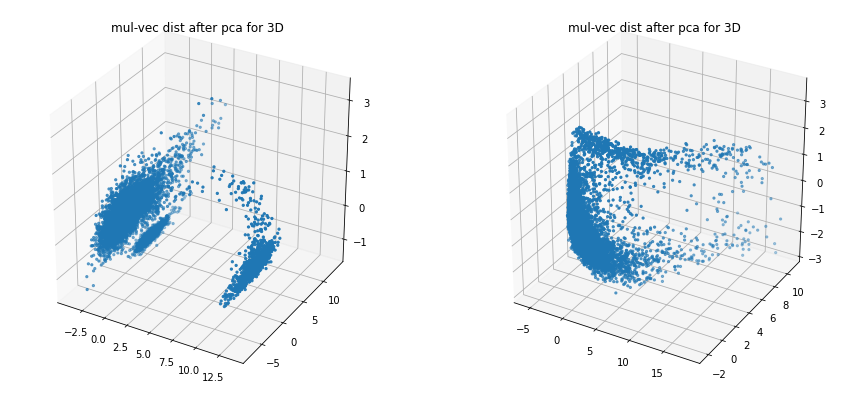

## 한글 번역한 경우 주성분분석
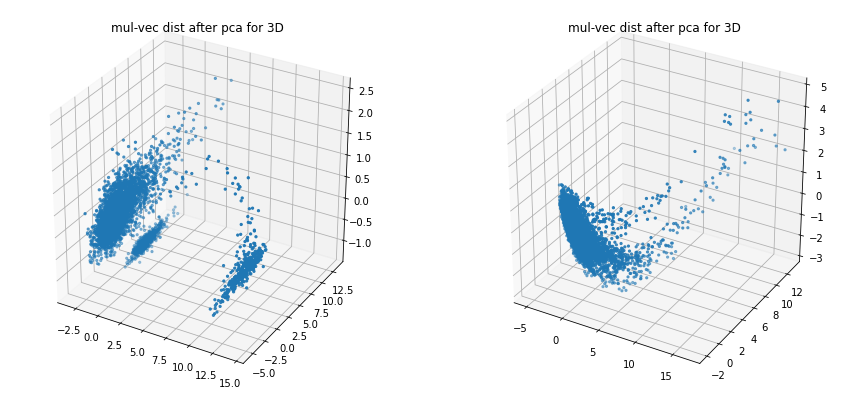
